## Imports

In [7]:
%matplotlib inline

from osgeo import osr, gdal

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import math

from PIL import Image, ImageDraw

sns.set(color_codes=True)

## Read location of Coco Trees

In [2]:
coco_tree = pd.read_csv('../data/tree_coconuts/locations.json', index_col=0)
coco_tree

x          y
0     -175.338616 -21.087592
1     -175.338541 -21.089580
2     -175.337749 -21.088268
3     -175.337780 -21.088143
4     -175.337803 -21.088248
5     -175.338165 -21.088149
6     -175.338028 -21.087524
7     -175.338004 -21.087576
8     -175.337944 -21.087596
9     -175.338017 -21.087675
10    -175.337896 -21.087674
11    -175.337902 -21.087725
12    -175.337878 -21.087784
13    -175.337783 -21.087777
14    -175.337701 -21.087787
15    -175.337572 -21.087734
16    -175.337491 -21.087730
17    -175.337454 -21.087673
18    -175.337511 -21.087663
19    -175.337547 -21.087550
20    -175.337591 -21.087541
21    -175.337648 -21.087533
22    -175.337678 -21.087646
23    -175.337670 -21.087710
24    -175.337768 -21.087659
25    -175.337821 -21.087615
26    -175.337739 -21.087570
27    -175.337581 -21.087442
28    -175.337629 -21.087435
29    -175.337690 -21.087429
...           ...        ...
10284 -175.347745 -21.101652
10285 -175.347616 -21.101750
10286 -175.347620 -21.101817
10287 -175.347632 -21.101875
10288 -175.347656 -21.101919
10289 -175.347657 -21.101962
10290 -175.347678 -21.101999
10291 -175.347702 -21.102071
10292 -175.347710 -21.102116
10293 -175.347726 -21.102150
10294 -175.347519 -21.101987
10295 -175.347485 -21.101912
10296 -175.347448 -21.101824
10297 -175.347474 -21.101857
10298 -175.347431 -21.101785
10299 -175.347444 -21.101732
10300 -175.347574 -21.102185
10301 -175.347612 -21.102224
10302 -175.347727 -21.102201
10303 -175.347749 -21.102245
10304 -175.347757 -21.102280
10305 -175.347754 -21.102345
10306 -175.347606 -21.102318
10307 -175.347628 -21.102375
10308 -175.347789 -21.102425
10309 -175.348195 -21.102432
10310 -175.347954 -21.102398
10311 -175.347847 -21.102325
10312 -175.347930 -21.102319
10313 -175.347974 -21.102349

[10314 rows x 2 columns]

## Reading Image

In [3]:
datafile = gdal.Open("../data/aerial_image/kolovai.tif")
bnd1 = datafile.GetRasterBand(1).ReadAsArray()
bnd2 = datafile.GetRasterBand(2).ReadAsArray()
bnd3 = datafile.GetRasterBand(3).ReadAsArray()
nx = datafile.RasterXSize # Raster xsize
ny = datafile.RasterYSize # Raster ysize

img = np.dstack((bnd1, bnd2, bnd3))

In [5]:
img = Image.fromarray(img)

print(img.size)

(17761, 25006)


In [12]:
img_w, img_h = img.size

slice_x = 1000
slice_y = 1000

Image.MAX_IMAGE_PIXELS = None

max_y = int(math.ceil(img_h/slice_y))
max_x = int(math.ceil(img_w/slice_x))


for y_start in range(0, max_y):
    for x_start in range(0, max_x):
        left = slice_x * x_start
        upper = slice_y * y_start
        bbox = (left, upper, left+slice_x, upper+slice_y)
        working_slice = img.crop(bbox)
        
        working_slice.save("../data/aerial_image/slices/slice__x_"+str(left)+"-"+str(left+slice_x)+"__y_"+ \
                           str(upper)+"-"+str(upper+slice_y)+".png")

### Retrieve Latitude and Longitude of Image

In [41]:
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(datafile.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs, new_cs) 

#get the point to transform, pixel (0,0) in this case
W = datafile.RasterXSize
H = datafile.RasterYSize
gt = datafile.GetGeoTransform()
minx = gt[0]
miny = gt[3] + W*gt[4] + H*gt[5] 
maxx = gt[0] + W*gt[1] + H*gt[2]
maxy = gt[3]

#get the coordinates in lat long
xgeo0, ygeo0, _ = transform.TransformPoint(minx, miny)
xgeoN, ygeoN, _ = transform.TransformPoint(maxx, maxy)

In [42]:
print(xgeo0, ygeo0)
print(xgeoN, ygeoN)

-175.34907207131698 -21.104930856349313
-175.33536665317192 -21.08692801644621


## Process and Chunk

### Coordinate Converter and Image Chunker

In [54]:
class Converter:
    def __init__(self, geo0, geoN, img_shape):
        self.xgeo0, self.ygeo0 = geo0
        self.xgeoN, self.ygeoN = geoN
        self.W, self.H = img_shape
        print(img_shape)
    
    def geo_2_pixel(self, x, y):
        x_pix = ((x - self.xgeo0)/abs(self.xgeoN - self.xgeo0)) * self.W
        y_pix = ((y - self.ygeo0)/abs(self.ygeoN - self.ygeo0)) * self.H
        
        return int(round(x_pix)), int(round(y_pix))

class ImageChunker:
    def __init__(self, img, img_shape):
        self.img = img
        self.H, self.W = img_shape
    
    def chunk(self, x, y, dx, dy):
        if x < 0 or x > self.W or y < 0 or y > self.H:
            return (None, None)
        
        x_start = x - dx
        
        if x_start < 0:
            dx = x
            return self.chunk(x, y, dx, dy)
        
        x_end = x + dx
        
        if x_end > self.W:
            dx = self.W - x
            return self.chunk(x, y, dx, dy)
        
        y_start = y - dy
        
        if y_start < 0:
            dy = y
            return self.chunk(x, y, dx, dy)
        
        y_end = y + dy
        
        if y_end > self.H:
            dy = self.H - y
            return self.chunk(x, y, dx, dy)
        
        tmp_img = self.img
        
        return (tmp_img[x_start: x_end, y_start: y_end], (dx, dy))

### Display Image Segment

In [55]:
def display_segment(loc_conv, handle_img, loc):
    x, y = loc_conv.geo_2_pixel(loc[0], loc[1])
    print(x,y)
    res = handle_image.chunk(x, y, 500, 300)
    if res[0] is not None:
        print(res[1])
        fig = plt.figure(figsize=(10,10))
        plt.imshow(res[0])
        plt.show()
    else:
        print("Image Error!\n\n")

### Iterate and Display some Images

(25006, 17761)
6869 6805
(500, 300)


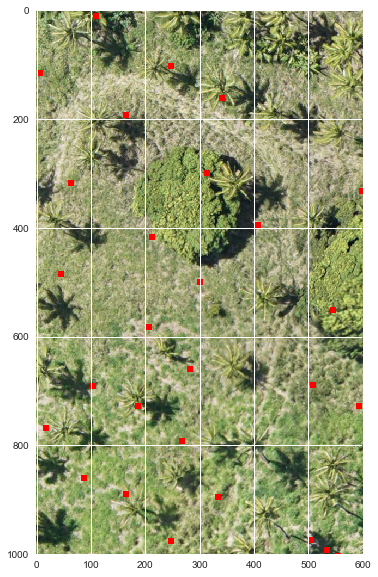

2060 17409
(500, 300)


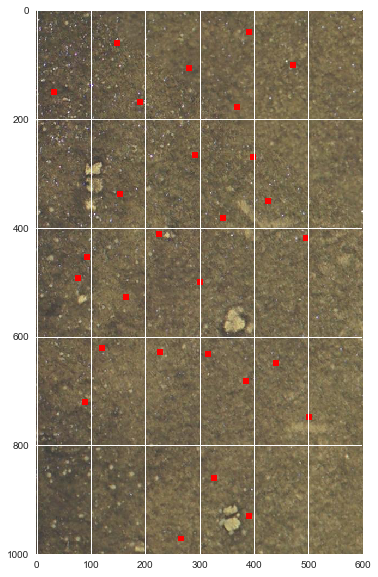

10209 16422
(500, 300)


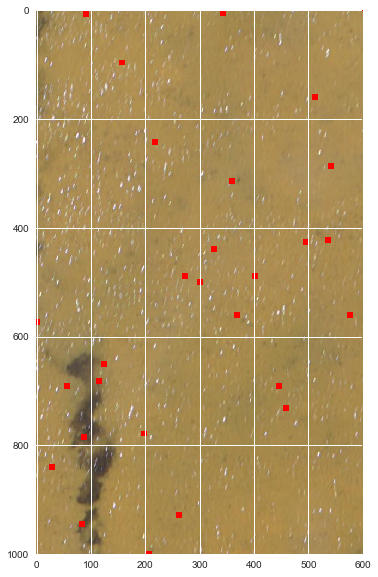

13893 15688
(500, 300)


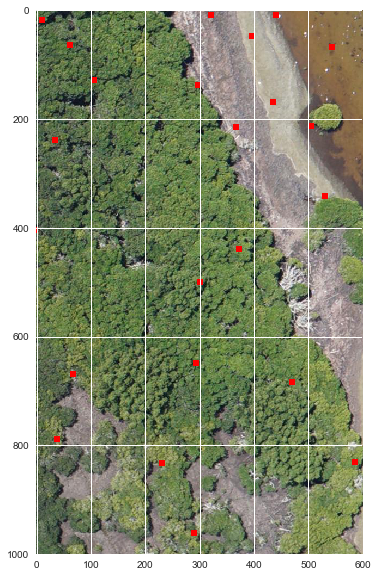

718 5193
(500, 300)


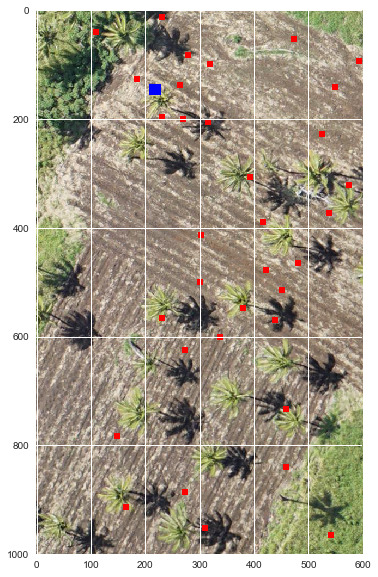

37 12321
(37, 300)


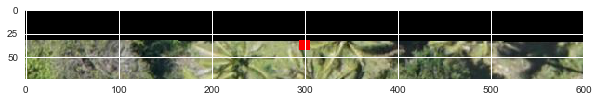

2113 1289
(500, 300)


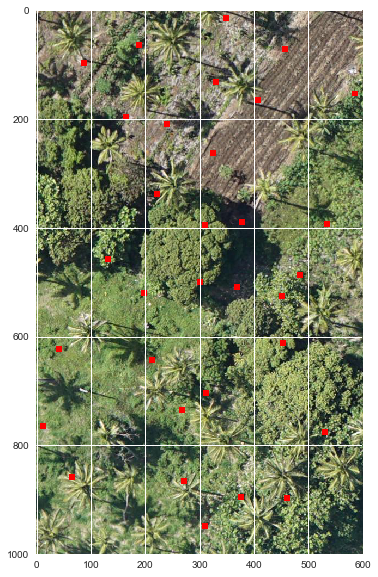

154 1811
(154, 300)


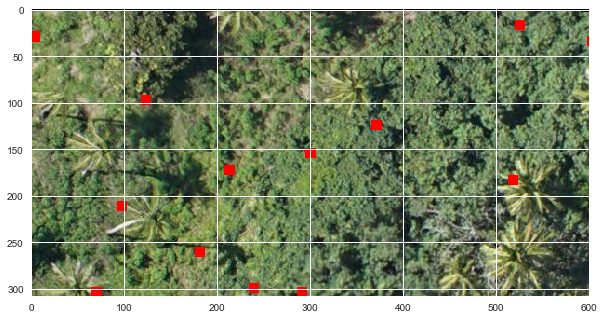

13178 6826
(500, 300)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


8168 13935
(500, 300)


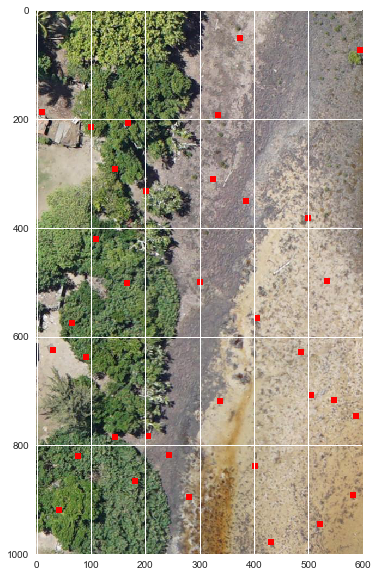

17758 10059
(3, 300)


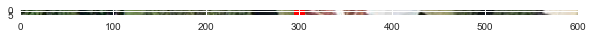

11117 6557
(500, 300)


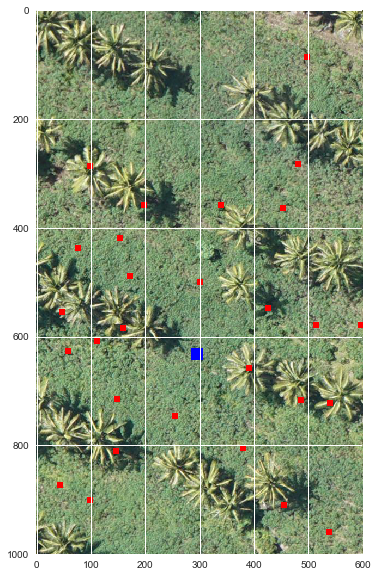

15332 13783
(500, 300)


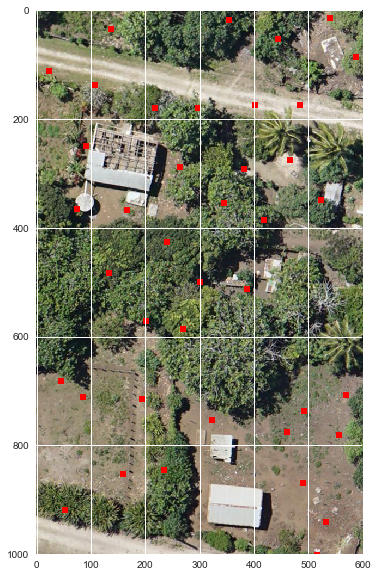

7097 6691
(500, 300)


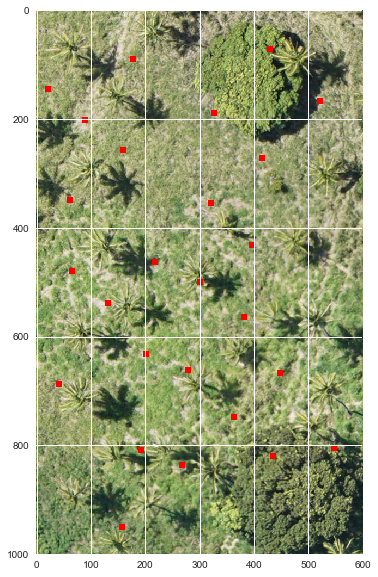

In [56]:
loc_converter = Converter((xgeo0, ygeo0), (xgeoN, ygeoN), img.shape[:2])
handle_image = ImageChunker(marked_img, marked_img.shape[:2])

for index, row in coco_tree.sample(15).iterrows():
    display_segment(loc_converter, handle_image, (row['x'], row['y']))

### Chunk to 1000 x 600 pixels images

In [49]:
from copy import deepcopy
loc_converter = Converter((xgeo0, ygeo0), (xgeoN, ygeoN), img.shape[:2])

marked_img = deepcopy(img)

for index, row in coco_tree.iterrows():
    x, y = loc_converter.geo_2_pixel(row['x'], row['y'])
    
    for a_x in range(x-5, x+6):
        for a_y in range(y-5, y+6):
            marked_img[a_x, a_y] = (255, 0, 0)
            

(25006, 17761)


In [31]:
plt.imsave('../data/aerial_image/marked.png', marked_img)

In [ ]:
for a_x in range(0, img.shape[1])